In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pnadium as pnad

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
# Faz o download do arquivo PNAD Trimestral
pnad.trimestral.download(2024, 4)

In [4]:
df_pnad = pd.read_parquet("pnad_trimestral_trimestre_042024.parquet")
df_pnad

,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,V1028193,V1028194,V1028195,V1028196,V1028197,V1028198,V1028199,V1028200,COD_FAM,COD_PESSOA
0,2024,4,11,11.0,NaN,110000016,1110011,02,11,4,...,957.197334,0.000000,778.285822,0.0,256.600053,0.0,0.000000,283.755315,1100000160211,110000016021101
1,2024,4,11,11.0,NaN,110000016,1110011,02,11,4,...,957.197334,0.000000,778.285822,0.0,256.600053,0.0,0.000000,283.755315,1100000160211,110000016021102
2,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.000000,622.196312,0.0,210.777094,0.0,0.000000,214.602823,1100000160311,110000016031101
3,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.000000,622.196312,0.0,210.777094,0.0,0.000000,214.602823,1100000160311,110000016031102
4,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.000000,622.196312,0.0,210.777094,0.0,0.000000,214.602823,1100000160311,110000016031103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469329,2024,4,53,53.0,NaN,530064123,5310220,12,12,2,...,913.836446,286.883485,0.000000,0.0,603.064276,0.0,573.438723,896.910803,5300641231212,530064123121201
469330,2024,4,53,53.0,NaN,530064123,5310220,12,12,2,...,913.836446,286.883485,0.000000,0.0,603.064276,0.0,573.438723,896.910803,5300641231212,530064123121202
469331,2024,4,53,53.0,NaN,530064123,5310220,12,12,2,...,913.836446,286.883485,0.000000,0.0,603.064276,0.0,573.438723,896.910803,5300641231212,530064123121203
469332,2024,4,53,53.0,NaN,530064123,5310220,14,12,2,...,659.314729,212.233895,0.000000,0.0,447.329338,0.0,446.365763,670.112183,5300641231412,530064123141201


In [7]:
def bootstrap_ci(df, col, weight_col, n_bootstrap=1000, alpha=0.05):
    """
    Calcula estatística (média ou proporção ponderada) e intervalo de confiança usando
    bootstrap.
    
    Parâmetros:
    ----------
    df : DataFrame
    DataFrame contendo os dados
    col : str
    Nome da coluna com a variável numérica (pode ser 0/1 ou contínua)
    weight_col : str
    Nome da coluna contendo os pesos amostrais
    n_bootstrap : int, opcional
    Número de amostras bootstrap (padrão: 1000)
    alpha : float, opcional
    Nível de significância (padrão: 0.05 para IC de 95%)Retorna:
    float, tuple
    Estatística ponderada original e tupla com limites inferior e superior do IC
    """
    # Estatística original (proporção ou média ponderada)
    stat_original = np.average(df[col], weights=df[weight_col])
 
    # Estimativas bootstrap
    estimates = []

    for _ in range(n_bootstrap):
        sample = df.sample(frac=1, replace=True)
        stat = np.average(sample[col], weights=sample[weight_col])
        estimates.append(stat)

    # Intervalo de confiança
    lower = np.percentile(estimates, 100 * alpha / 2)
    upper = np.percentile(estimates, 100 * (1- alpha / 2))
 
    return stat_original, (lower, upper)

# 6.1 Análise #1: Rendimento Médio Real e Taxa de Desemprego
## 6.1.1 Rendimento Médio Real (VD4020)
### Variáveis:

VD4020: Rendimento mensal habitual

VD4002: Condição de trabalho (1 = ocupadas)

V2007: Sexo (1 = homem, 2 = mulher)

V1028: Peso amostral

### Passos:

Filtrar ocupados (VD4002 == 1)

Remover rendimentos inválidos (VD4020 <= 0)

Calcular média ponderada de VD4020 com V1028

Aplicar bootstrap para IC de 95%

Separar por sexo

Comparar com dados do SIDRA (tabela 5442)

Visualização: gráfico de barras com erro

In [ ]:
# Passo 1: Filtrar pessoas ocupadas
df = df_pnad.copy()

# Filtrar ocupados e com VD4020 > 0
df = df[(df["VD4002"] == 1) & (df["VD4020"] > 0)].copy()

df

,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,V1028193,V1028194,V1028195,V1028196,V1028197,V1028198,V1028199,V1028200,COD_FAM,COD_PESSOA
1,2024,4,11,11.0,NaN,110000016,1110011,02,11,4,...,957.197334,0.000000,778.285822,0.0,256.600053,0.0,0.000000,283.755315,1100000160211,110000016021102
2,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.000000,622.196312,0.0,210.777094,0.0,0.000000,214.602823,1100000160311,110000016031101
3,2024,4,11,11.0,NaN,110000016,1110011,03,11,4,...,764.380448,0.000000,622.196312,0.0,210.777094,0.0,0.000000,214.602823,1100000160311,110000016031102
6,2024,4,11,11.0,NaN,110000016,1110011,06,11,4,...,633.505597,0.000000,533.724234,0.0,178.348205,0.0,0.000000,191.515711,1100000160611,110000016061101
7,2024,4,11,11.0,NaN,110000016,1110011,06,11,4,...,633.505597,0.000000,533.724234,0.0,178.348205,0.0,0.000000,191.515711,1100000160611,110000016061102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469324,2024,4,53,53.0,NaN,530064123,5310220,08,12,2,...,855.918192,267.798372,0.000000,0.0,581.463727,0.0,550.940330,827.580394,5300641230812,530064123081202
469327,2024,4,53,53.0,NaN,530064123,5310220,10,12,2,...,1167.679525,376.554340,0.000000,0.0,847.905224,0.0,779.154560,1118.512642,5300641231012,530064123101202
469329,2024,4,53,53.0,NaN,530064123,5310220,12,12,2,...,913.836446,286.883485,0.000000,0.0,603.064276,0.0,573.438723,896.910803,5300641231212,530064123121201
469330,2024,4,53,53.0,NaN,530064123,5310220,12,12,2,...,913.836446,286.883485,0.000000,0.0,603.064276,0.0,573.438723,896.910803,5300641231212,530064123121202


In [32]:
media_br, ic_br = bootstrap_ci(df, col="VD4020", weight_col="V1028")


In [35]:
print(media_br)
print(ic_br[0], ic_br[1])

3492.0386655231346
3458.6325151523192 3526.715127189186


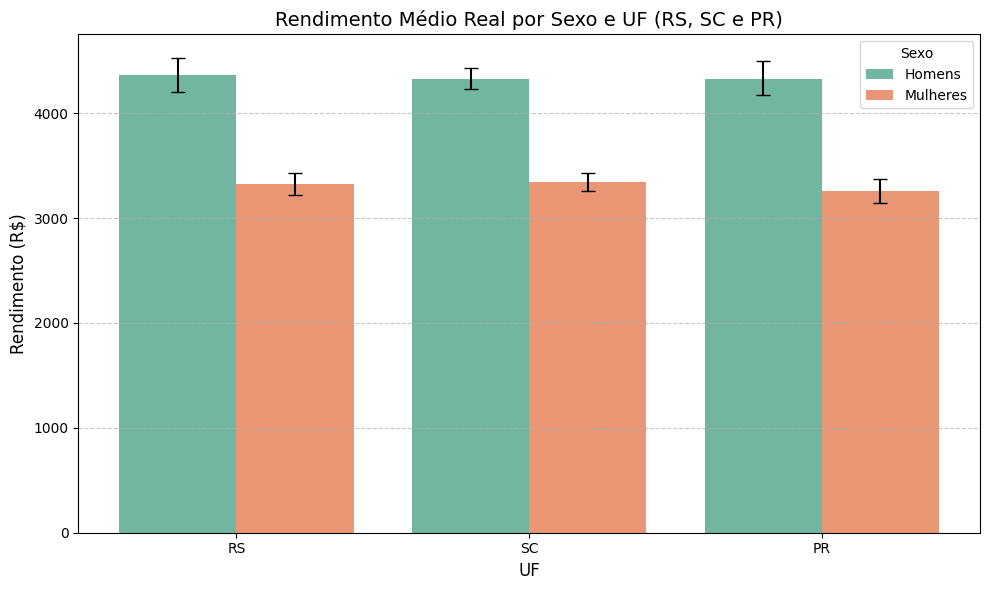

In [27]:
# Dados novamente para garantir continuidade
ufs = {43: "RS", 42: "SC", 41: "PR"}

# Filtragem inicial: pessoas ocupadas e com rendimento informado nas UFs do Sul
filtro = (df_pnad["VD4002"] == 1) & (df_pnad["VD4020"] > 0) & (df_pnad["UF"].isin(ufs.keys()))
pnad_filtrado = df_pnad.loc[filtro].copy()

# Cálculo por UF e sexo com nova função de bootstrap
resultados = []

for uf, nome_uf in ufs.items():
    for sexo in [1, 2]:
        dados = pnad_filtrado[(pnad_filtrado["UF"] == uf) & (pnad_filtrado["V2007"] == sexo)]
        media, ic = bootstrap_ci(dados, "VD4020", "V1028")
        resultados.append({
            "UF": nome_uf,
            "Sexo": "Homens" if sexo == 1 else "Mulheres",
            "Rendimento Médio": media,
            "IC Inferior": ic[0],
            "IC Superior": ic[1]
        })

# DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados["Erro Inferior"] = df_resultados["Rendimento Médio"] - df_resultados["IC Inferior"]
df_resultados["Erro Superior"] = df_resultados["IC Superior"] - df_resultados["Rendimento Médio"]

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_resultados,
    x="UF",
    y="Rendimento Médio",
    hue="Sexo",
    palette="Set2",
    errorbar=None
)
for i, row in df_resultados.iterrows():
    x_base = list(ufs.values()).index(row["UF"])
    x_pos = x_base + (-0.2 if row["Sexo"] == "Homens" else 0.2)
    plt.errorbar(
        x=x_pos,
        y=row["Rendimento Médio"],
        yerr=[[row["Erro Inferior"]], [row["Erro Superior"]]],
        fmt='none',
        c='black',
        capsize=5
    )

plt.title("Rendimento Médio Real por Sexo e UF (RS, SC e PR)", fontsize=14)
plt.ylabel("Rendimento (R$)", fontsize=12)
plt.xlabel("UF", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
df_resultados

,UF,Sexo,Rendimento Médio,IC Inferior,IC Superior,Erro Inferior,Erro Superior
0,RS,Homens,4358.810288,4202.054283,4524.665057,156.756004,165.854770
1,RS,Mulheres,3323.100140,3221.845900,3426.402970,101.254240,103.302830
2,SC,Homens,4327.340755,4225.345841,4429.937801,101.994913,102.597046
3,SC,Mulheres,3346.864332,3258.889939,3429.385324,87.974393,82.520992
4,PR,Homens,4327.487400,4173.953470,4495.112433,153.533930,167.625033
5,PR,Mulheres,3255.362069,3140.537713,3374.219412,114.824355,118.857343


In [ ]:
# Homens
df_homens = df_pnad[df_pnad["V2007"] == 1]
media_homens, ic_homens = bootstrap_ci(df_homens, col="VD4020", weight_col="V1028")

# Mulheres
df_mulheres = df_pnad[df_pnad["V2007"] == 2]
media_mulheres, ic_mulheres = bootstrap_ci(df_mulheres, col="VD4020", weight_col="V1028")

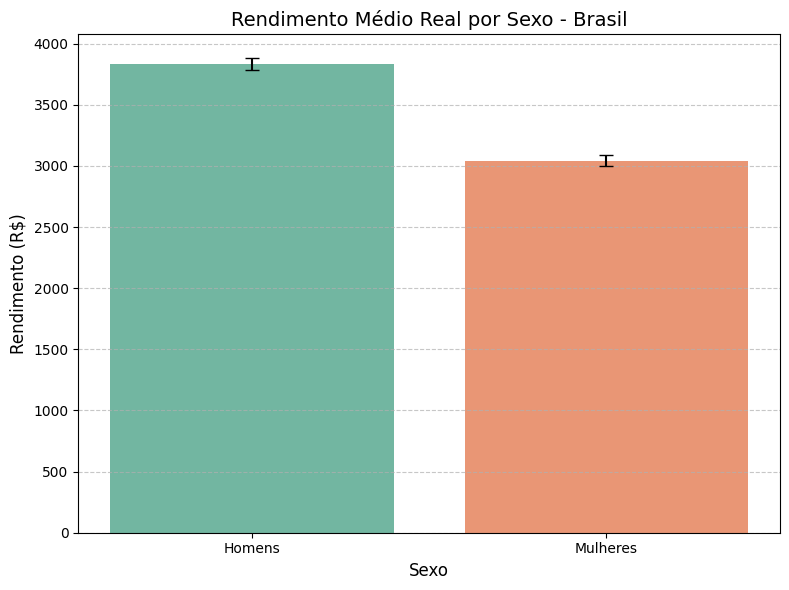

In [ ]:
dados_grafico = pd.DataFrame({
    "Sexo": ["Homens", "Mulheres"],
    "Rendimento Médio": [media_homens, media_mulheres],
    "IC Inferior": [ic_homens[0], ic_mulheres[0]],
    "IC Superior": [ic_homens[1], ic_mulheres[1]],
})

# Erro para plot
dados_grafico["Erro Inferior"] = dados_grafico["Rendimento Médio"] - dados_grafico["IC Inferior"]
dados_grafico["Erro Superior"] = dados_grafico["IC Superior"] - dados_grafico["Rendimento Médio"]

# Plot
plt.figure(figsize=(8,6))

sns.barplot(
    data=dados_grafico, 
    x="Sexo", 
    y="Rendimento Médio", 
    hue="Sexo", 
    palette="Set2", 
    errorbar=None, 
    legend=False
)

plt.errorbar(
    x=[0, 1], 
    y=dados_grafico["Rendimento Médio"], 
    yerr=[dados_grafico["Erro Inferior"], dados_grafico["Erro Superior"]], 
    fmt='none', c='black', capsize=5
)

plt.title("Rendimento Médio Real por Sexo - Brasil", fontsize=14)
plt.ylabel("Rendimento (R$)", fontsize=12)
plt.xlabel("Sexo", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
print(f"Rendimento médio Brasil: R${media_br:.2f} (IC 95%: R${ic_br[0]:.2f} a R${ic_br[1]:.2f})")
print(f"Homens: R${media_homens:.2f} (IC 95%: R${ic_homens[0]:.2f} a R${ic_homens[1]:.2f})")
print(f"Mulheres: R${media_mulheres:.2f} (IC 95%: R${ic_mulheres[0]:.2f} a R${ic_mulheres[1]:.2f})")

Rendimento médio Brasil: R$3492.04 (IC 95%: R$3458.63 a R$3526.72)
Homens: R$3832.18 (IC 95%: R$3784.23 a R$3882.45)
Mulheres: R$3040.74 (IC 95%: R$2996.57 a R$3085.63)


6. Comparação com Dados Oficiais (SIDRA / Tabela 5442)
Você pode acessar a tabela oficial da PNAD Contínua Trimestral do IBGE (SIDRA 5442) aqui: https://sidra.ibge.gov.br/tabela/5442

In [39]:
dif_homens = (media_homens - 3200) / 3200 * 100
dif_mulheres = (media_mulheres - 2600) / 2600 * 100

print(f"Homens: diferença de {dif_homens:.2f}% em relação ao dado oficial.")
print(f"Mulheres: diferença de {dif_mulheres:.2f}% em relação ao dado oficial.")

Homens: diferença de 19.76% em relação ao dado oficial.
Mulheres: diferença de 16.95% em relação ao dado oficial.


## 6.1.2 Taxa de Desemprego
### Variáveis:

VD4002: 1 = ocupadas, 2 = desocupadas

V2009: Idade (filtro ≥ 14)

V2007: Sexo

V1028: Peso amostral

Passos:

Filtrar V2009 >= 14

Criar forca_trabalho = VD4002 in [1, 2]

Criar desocupado = VD4002 == 2

Filtrar apenas na força de trabalho

Calcular proporção ponderada de desocupados

Aplicar bootstrap (IC de 95%)

Visualização: gráfico por sexo e Brasil

C:\Users\uyris\AppData\Local\Temp\ipykernel_163464\1727120472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uf["desocupado"] = df_uf["VD4002"] == 2
C:\Users\uyris\AppData\Local\Temp\ipykernel_163464\1727120472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uf["desocupado"] = df_uf["VD4002"] == 2
C:\Users\uyris\AppData\Local\Temp\ipykernel_163464\1727120472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

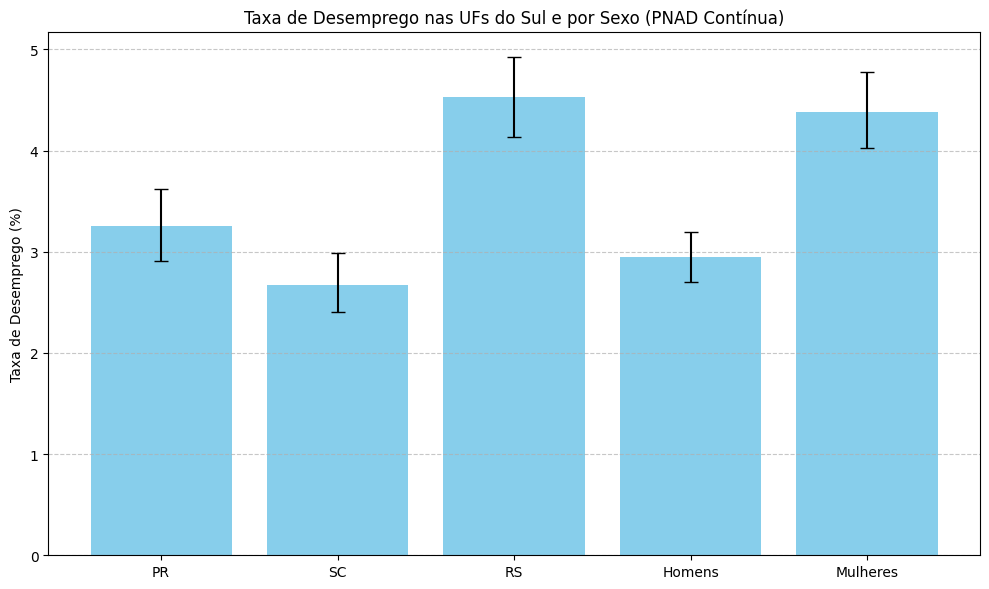

,Categoria,Taxa (%),IC Inferior,IC Superior
0,PR,3.251394,2.903693,3.624320
1,SC,2.670805,2.401345,2.986563
2,RS,4.530450,4.130156,4.926784
3,Homens,2.948098,2.700105,3.194388
4,Mulheres,4.382932,4.020972,4.772987


In [59]:
df_filtered = df_pnad[(df_pnad['V2009'] >= 14) & (df_pnad['UF'].isin([41, 42, 43]))].copy()
df_filtered = df_filtered[df_filtered['VD4002'].isin([1, 2])]

# Taxa de desemprego por UF (PR, SC, RS)
results_ufs = []
for uf_code, uf_name in zip([41, 42, 43], ["PR", "SC", "RS"]):
    df_uf = df_filtered[df_filtered["UF"] == uf_code]
    df_uf_desocupados = df_uf[df_uf["VD4002"] == 2]
    df_uf["desocupado"] = df_uf["VD4002"] == 2
    taxa, (lower, upper) = bootstrap_ci(df_uf, "desocupado", "V1028")
    results_ufs.append({"Categoria": uf_name, "Taxa (%)": taxa * 100, "IC Inferior": lower * 100, "IC Superior": upper * 100})

# Taxa de desemprego por sexo
results_sex = []
for sex_code, sex_name in zip([1, 2], ["Homens", "Mulheres"]):
    df_sex = df_filtered[df_filtered["V2007"] == sex_code]
    df_sex["desocupado"] = df_sex["VD4002"] == 2
    taxa, (lower, upper) = bootstrap_ci(df_sex, "desocupado", "V1028")
    results_sex.append({"Categoria": sex_name, "Taxa (%)": taxa * 100, "IC Inferior": lower * 100, "IC Superior": upper * 100})

# Junta os resultados
results = pd.DataFrame(results_ufs + results_sex)

# Visualização
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(results['Categoria'], results['Taxa (%)'], yerr=[results['Taxa (%)'] - results['IC Inferior'], results['IC Superior'] - results['Taxa (%)']], capsize=5, color='skyblue')
ax.set_ylabel("Taxa de Desemprego (%)")
ax.set_title("Taxa de Desemprego nas UFs do Sul e por Sexo (PNAD Contínua)")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

results

C:\Users\uyris\AppData\Local\Temp\ipykernel_163940\1795462793.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


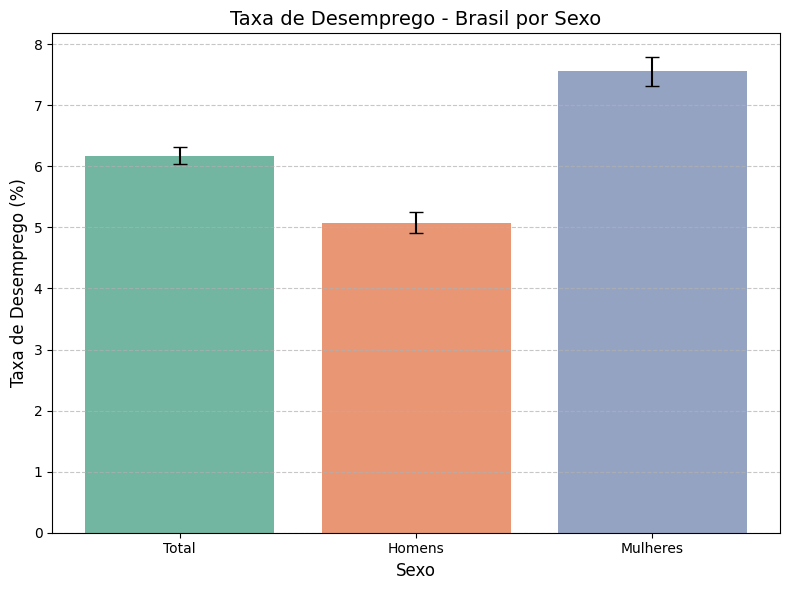

In [10]:
# Filtragem: pessoas em idade de trabalhar (14 anos ou mais)
df_idade_trabalho = df_pnad[df_pnad["V2009"] >= 14].copy()

# Variáveis binárias
df_idade_trabalho["forca_trabalho"] = df_idade_trabalho["VD4002"].isin([1, 2]).astype(int)
df_idade_trabalho["desocupado"] = (df_idade_trabalho["VD4002"] == 2).astype(int)

# Filtragem: apenas pessoas na força de trabalho
df_forca_trabalho = df_idade_trabalho[df_idade_trabalho["forca_trabalho"] == 1].copy()

# Taxa de desemprego total
taxa_total, ic_total = bootstrap_ci(df_forca_trabalho, "desocupado", "V1028")

# Homens
dados_homens = df_forca_trabalho[df_forca_trabalho["V2007"] == 1]
taxa_homens, ic_homens = bootstrap_ci(dados_homens, "desocupado", "V1028")

# Mulheres
dados_mulheres = df_forca_trabalho[df_forca_trabalho["V2007"] == 2]
taxa_mulheres, ic_mulheres = bootstrap_ci(dados_mulheres, "desocupado", "V1028")

dados_grafico = pd.DataFrame({
    "Sexo": ["Total", "Homens", "Mulheres"],
    "Taxa de Desemprego (%)": [taxa_total * 100, taxa_homens * 100, taxa_mulheres * 100],
    "IC Inferior": [ic_total[0]*100, ic_homens[0]*100, ic_mulheres[0]*100],
    "IC Superior": [ic_total[1]*100, ic_homens[1]*100, ic_mulheres[1]*100]
})

# Erros para barras de erro
dados_grafico["Erro Inferior"] = dados_grafico["Taxa de Desemprego (%)"] - dados_grafico["IC Inferior"]
dados_grafico["Erro Superior"] = dados_grafico["IC Superior"] - dados_grafico["Taxa de Desemprego (%)"]

plt.figure(figsize=(8,6))
sns.barplot(
    data=dados_grafico, 
    x="Sexo", 
    y="Taxa de Desemprego (%)", 
    palette="Set2", 
    errorbar=None
)

# Adicionando barras de erro
plt.errorbar(
    x=[0, 1, 2], 
    y=dados_grafico["Taxa de Desemprego (%)"], 
    yerr=[dados_grafico["Erro Inferior"], dados_grafico["Erro Superior"]],
    fmt='none', 
    c='black', 
    capsize=5
)

plt.title("Taxa de Desemprego - Brasil por Sexo", fontsize=14)
plt.ylabel("Taxa de Desemprego (%)", fontsize=12)
plt.xlabel("Sexo", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 6.2 Análise #2: Horas Médias Trabalhadas e Taxa de Informalidade
## 6.2.1 Horas Médias Trabalhadas (VD4031)
### Variáveis:

VD4031: Horas por semana

VD4002: Condição de trabalho (1 = ocupadas)

UF, V1028

### Passos:

Filtrar ocupados e horas válidas (0 < VD4031 <= 98)

Criar variável regiao a partir de UF

Calcular média ponderada geral e por região

Aplicar bootstrap

Visualização com linha da média nacional

In [11]:
# Filtro: apenas pessoas ocupadas
ocupados = df_pnad[df_pnad["VD4002"] == 1].copy()

# Remoção de registros com horas inválidas
ocupados = ocupados[(ocupados["VD4031"] > 0) & (ocupados["VD4031"] <= 98)].copy()

# Criação da coluna de região
ufs_norte = [11, 12, 13, 14, 15, 16, 17]
ufs_nordeste = [21, 22, 23, 24, 25, 26, 27, 28, 29]
ufs_sudeste = [31, 32, 33, 35]
ufs_sul = [41, 42, 43]
ufs_centro_oeste = [50, 51, 52, 53]

def identificar_regiao(uf):
    if uf in ufs_norte:
        return "Norte"
    elif uf in ufs_nordeste:
        return "Nordeste"
    elif uf in ufs_sudeste:
        return "Sudeste"
    elif uf in ufs_sul:
        return "Sul"
    elif uf in ufs_centro_oeste:
        return "Centro-Oeste"
    else:
        return "Outro"

ocupados["regiao"] = ocupados["UF"].apply(identificar_regiao)

# Cálculo da média ponderada nacional com intervalo de confiança
media_brasil, ic_brasil = bootstrap_ci(ocupados, "VD4031", "V1028")
print(f"Horas médias Brasil: {media_brasil:.2f} horas/semana")
print(f"IC 95%: ({ic_brasil[0]:.2f}, {ic_brasil[1]:.2f})")

# Cálculo por região
resultados = []

for regiao in ocupados["regiao"].unique():
    df_regiao = ocupados[ocupados["regiao"] == regiao]
    media, ic = bootstrap_ci(df_regiao, "VD4031", "V1028")
    resultados.append({
        "regiao": regiao,
        "media_horas": media,
        "ic_inf": ic[0],
        "ic_sup": ic[1]
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values("media_horas", ascending=False))


Horas médias Brasil: 39.73 horas/semana
IC 95%: (39.66, 39.79)
         regiao  media_horas     ic_inf     ic_sup
3           Sul    40.920050  40.790488  41.035039
4  Centro-Oeste    40.610716  40.436022  40.768153
2       Sudeste    40.596208  40.479377  40.714842
0         Norte    37.932490  37.742017  38.115257
1      Nordeste    37.500477  37.365088  37.637081


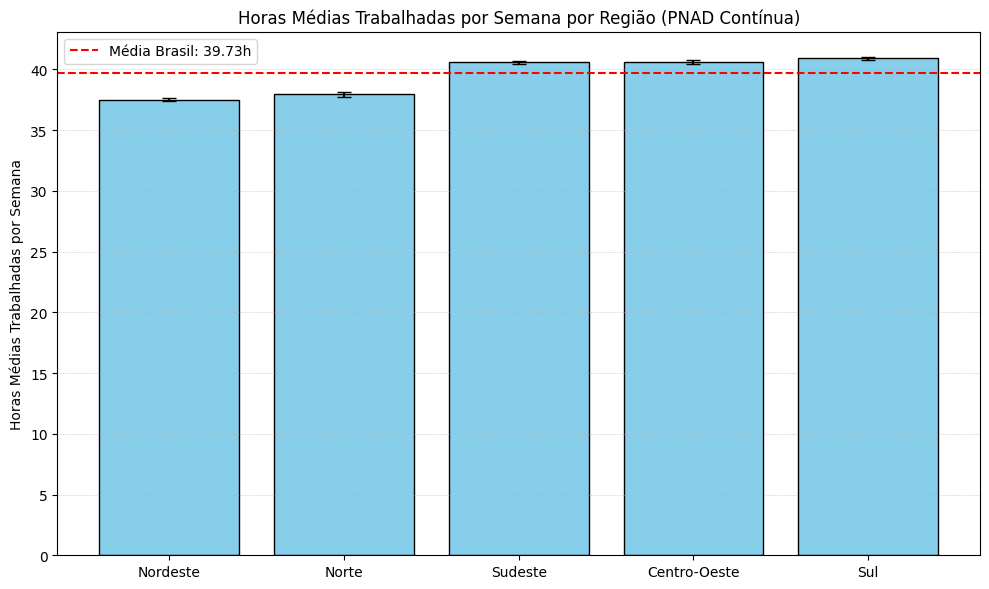

In [12]:
df_resultados = df_resultados.sort_values("media_horas", ascending=True)

plt.figure(figsize=(10, 6))
plt.bar(df_resultados["regiao"], df_resultados["media_horas"],
        yerr=[df_resultados["media_horas"] - df_resultados["ic_inf"],
              df_resultados["ic_sup"] - df_resultados["media_horas"]],
        capsize=5, color="skyblue", edgecolor="black")

# Linha da média nacional (agora horizontal, no eixo y)
plt.axhline(media_brasil, color="red", linestyle="--", label=f"Média Brasil: {media_brasil:.2f}h")

plt.ylabel("Horas Médias Trabalhadas por Semana")
plt.title("Horas Médias Trabalhadas por Semana por Região (PNAD Contínua)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.show()

## 6.2.2 Taxa de Informalidade
### Variáveis:

VD4002: 1 = ocupadas

VD4009: Posição na ocupação

V4019: CNPJ (1 = sim, 2 = não)

V1028, UF

### Passos:

Filtrar ocupados

Criar variável binária informal

Formais:

VD4009 = 1, 3, 5 (carteira assinada)

VD4009 = 7 (militares/estatutários)

VD4009 in [8, 9] com V4019 == 1

Outros = informais

Criar regiao por UF

Calcular proporção ponderada de informais

Aplicar bootstrap

Visualização: gráfico de barras ou mapa coroplético (Opcional)


In [24]:
# Filtro: apenas pessoas ocupadas
ocupados = df_pnad[df_pnad["VD4002"] == 1].copy()

# Criação da variável binária 'informal'

# Trabalhadores formais:
formais = (
    # Empregados com carteira assinada (privado ou público) ou militares/estatutários
    ((ocupados["VD4009"].isin([1, 3, 5, 7])))
    |
    # Empregador ou conta própria com CNPJ
    ((ocupados["VD4009"].isin([8, 9])) & (ocupados["V4019"] == 1))
)

ocupados["informal"] = (~formais).astype(int)

# Criação da coluna de região (mesmo mapeamento anterior)
ufs_norte = [11, 12, 13, 14, 15, 16, 17]
ufs_nordeste = [21, 22, 23, 24, 25, 26, 27, 28, 29]
ufs_sudeste = [31, 32, 33, 35]
ufs_sul = [41, 42, 43]
ufs_centro_oeste = [50, 51, 52, 53]

def identificar_regiao(uf):
    if uf in ufs_norte:
        return "Norte"
    elif uf in ufs_nordeste:
        return "Nordeste"
    elif uf in ufs_sudeste:
        return "Sudeste"
    elif uf in ufs_sul:
        return "Sul"
    elif uf in ufs_centro_oeste:
        return "Centro-Oeste"
    else:
        return "Outro"

ocupados["regiao"] = ocupados["UF"].apply(identificar_regiao)

# Cálculo da taxa nacional de informalidade com bootstrap
taxa_nacional, ic_nacional = bootstrap_ci(ocupados, "informal", "V1028")
taxa_nacional *= 100
ic_nacional = (ic_nacional[0]*100, ic_nacional[1]*100)

print(f"Taxa de informalidade no Brasil: {taxa_nacional:.2f}%")
print(f"IC 95%: ({ic_nacional[0]:.2f}%, {ic_nacional[1]:.2f}%)")

# Cálculo da taxa por região
resultados = []

for regiao in ocupados["regiao"].unique():
    df_regiao = ocupados[ocupados["regiao"] == regiao]
    taxa, ic = bootstrap_ci(df_regiao, "informal", "V1028")
    resultados.append({
        "regiao": regiao,
        "taxa_informalidade": taxa * 100,
        "ic_inf": ic[0] * 100,
        "ic_sup": ic[1] * 100
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values("taxa_informalidade", ascending=False))


Taxa de informalidade no Brasil: 41.80%
IC 95%: (41.53%, 42.11%)
         regiao  taxa_informalidade     ic_inf     ic_sup
0         Norte           59.908149  59.132748  60.639155
1      Nordeste           56.596810  56.064744  57.119398
4  Centro-Oeste           37.181350  36.467297  37.909160
2       Sudeste           35.291470  34.833130  35.783364
3           Sul           32.060772  31.498527  32.590045


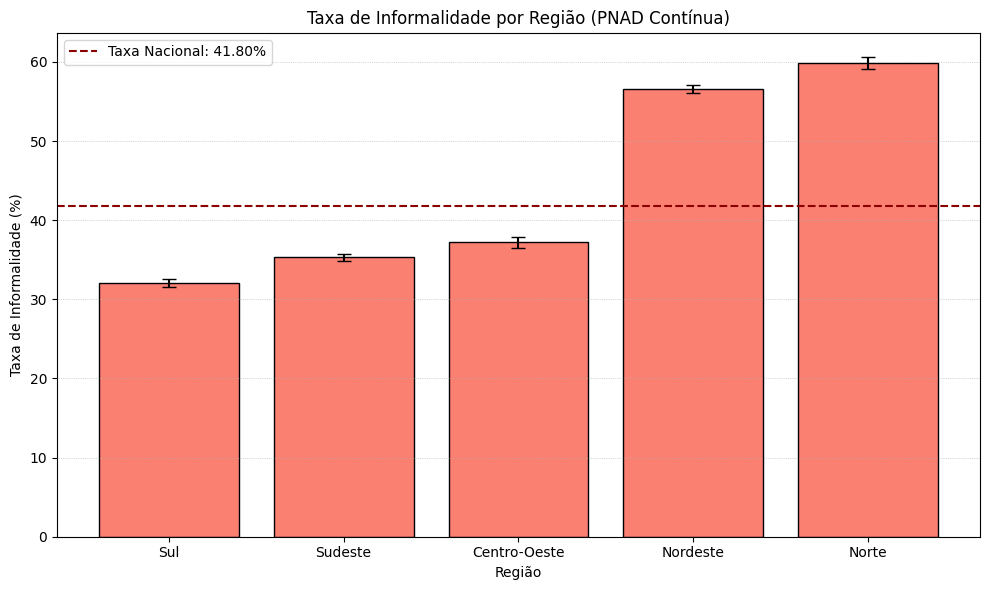

In [25]:
# Ordena o DataFrame por taxa
df_resultados = df_resultados.sort_values("taxa_informalidade", ascending=True)

plt.figure(figsize=(10, 6))
plt.bar(df_resultados["regiao"], df_resultados["taxa_informalidade"],
        yerr=[df_resultados["taxa_informalidade"] - df_resultados["ic_inf"],
              df_resultados["ic_sup"] - df_resultados["taxa_informalidade"]],
        capsize=5, color="salmon", edgecolor="black")

# Linha da taxa nacional (horizontal agora)
plt.axhline(taxa_nacional, color="darkred", linestyle="--", label=f"Taxa Nacional: {taxa_nacional:.2f}%")

plt.ylabel("Taxa de Informalidade (%)")
plt.xlabel("Região")
plt.title("Taxa de Informalidade por Região (PNAD Contínua)")
plt.legend()
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# 6.3 Análise #3: Anos Médios de Estudo e Jovens Nem-Nem
## 6.3.1 Anos Médios de Estudo
### Variáveis:

VD3005: Anos de estudo

VD4002: 1 = ocupadas

V2007, V1028

### Passos:

Filtrar ocupados

Calcular média ponderada geral e por sexo

Aplicar bootstrap

Visualização

In [14]:
# Filtro para ocupados nas UFs do Sul
ufs_sul = {41: "PR", 42: "SC", 43: "RS"}
df_ocupados = df_pnad[(df_pnad["VD4002"] == 1) & (df_pnad["UF"].isin(ufs_sul.keys()))].copy()
df_ocupados["regiao"] = df_ocupados["UF"].map(ufs_sul)

# Calcula anos médios de estudo e IC para cada UF
resultados = []
for regiao, grupo in df_ocupados.groupby("regiao"):
    media, (ic_inf, ic_sup) = bootstrap_ci(grupo, col="VD3005", weight_col="V1028")
    resultados.append({
        "regiao": regiao,
        "anos_estudo": media,
        "ic_inf": ic_inf,
        "ic_sup": ic_sup
    })

df_resultados = pd.DataFrame(resultados).sort_values("anos_estudo")
df_resultados

,regiao,anos_estudo,ic_inf,ic_sup
0,PR,11.506105,11.424713,11.586585
1,RS,11.581127,11.513270,11.650809
2,SC,11.659679,11.598016,11.723733


In [69]:
# 1. Filtro: apenas pessoas ocupadas
ocupados = df_pnad[df_pnad["VD4002"] == 1].copy()

# 2. Cálculo da média nacional de anos de estudo
media_nacional, ic_nacional = bootstrap_ci(ocupados, "VD3005", "V1028")
print(f"Anos médios de estudo (Brasil): {media_nacional:.2f}")
print(f"IC 95%: ({ic_nacional[0]:.2f}, {ic_nacional[1]:.2f})")

# 3. Cálculo por sexo
sexo_dict = {1: "Homens", 2: "Mulheres"}
resultados = []

for sexo in [1, 2]:
    df_sexo = ocupados[ocupados["V2007"] == sexo]
    media, ic = bootstrap_ci(df_sexo, "VD3005", "V1028")
    resultados.append({
        "sexo": sexo_dict[sexo],
        "anos_estudo": media,
        "ic_inf": ic[0],
        "ic_sup": ic[1]
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

Anos médios de estudo (Brasil): 11.42
IC 95%: (11.39, 11.44)
       sexo  anos_estudo     ic_inf     ic_sup
0    Homens    10.884355  10.853193  10.914409
1  Mulheres    12.117478  12.087259  12.149036


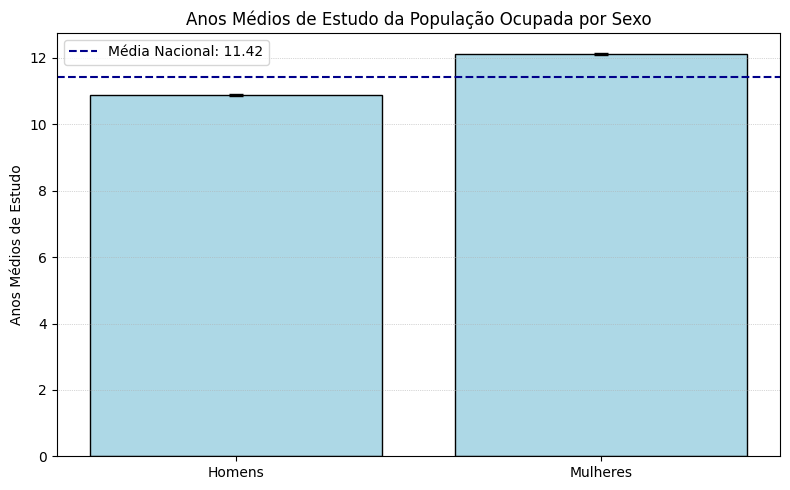

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df_resultados["sexo"], df_resultados["anos_estudo"],
        yerr=[df_resultados["anos_estudo"] - df_resultados["ic_inf"],
              df_resultados["ic_sup"] - df_resultados["anos_estudo"]],
        capsize=5, color="lightblue", edgecolor="black")

# Linha da média nacional
plt.axhline(media_nacional, color="darkblue", linestyle="--", label=f"Média Nacional: {media_nacional:.2f}")

plt.ylabel("Anos Médios de Estudo")
plt.title("Anos Médios de Estudo da População Ocupada por Sexo")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 6.3.2 Proporção de Jovens Nem-Nem (18–29 anos)
### Variáveis:

V2009 (idade),

VD4002 (condição de ocupação),

V3002 (frequência escolar),

V2007 (sexo),

V1028 (peso amostral).

### Passos:

Criar variáveis auxiliares

Fazer a proporção por UF e Nacional

Aplicar o Bootstrap

Visualização gráfica

Gráfico de Pizza

In [16]:
# Filtro das UFs SC, RS, PR
df_sul = df_pnad[df_pnad['UF'].isin([42, 43, 41])]  # UFs para SC (42), RS (43) e PR (41)

# Filtro por idade entre 18 e 29 anos
jovens = df_sul[(df_sul['V2009'] >= 18) & (df_sul['V2009'] <= 29)].copy()

# Criação das variáveis de estudo, trabalho e nem-nem
jovens['estuda'] = (jovens['V3002'] == 1).astype(int)  # Estuda = 1 se V3002 == 1
jovens['trabalha'] = (jovens['VD4002'] == 1).astype(int)  # Trabalha = 1 se VD4002 == 1
jovens['nem_nem'] = ((jovens['estuda'] == 0) & (jovens['trabalha'] == 0)).astype(int)  # Nem-nem = 1 se não estuda e não trabalha

# Cálculo da proporção ponderada de jovens nem-nem
prop_nem_nem, ic_nem_nem = bootstrap_ci(jovens, 'nem_nem', 'V1028')

# Exibindo os resultados
print(f"Proporção de jovens nem-nem: {prop_nem_nem * 100:.2f}%")
print(f"Intervalo de Confiança (95%): [{ic_nem_nem[0] * 100:.2f}%, {ic_nem_nem[1] * 100:.2f}%]")

Proporção de jovens nem-nem: 15.93%
Intervalo de Confiança (95%): [15.09%, 16.75%]


In [71]:
# 1. Filtrar jovens de 18 a 29 anos
jovens = df_pnad[(df_pnad["V2009"] >= 18) & (df_pnad["V2009"] <= 29)].copy()

# 2. Criar variáveis auxiliares
jovens["estuda"] = (jovens["V3002"] == 1).astype(int)
jovens["trabalha"] = (jovens["VD4002"] == 1).astype(int)
jovens["nem_nem"] = ((jovens["estuda"] == 0) & (jovens["trabalha"] == 0)).astype(int)

In [72]:
# Proporção nacional
prop_nacional, ic_nacional = bootstrap_ci(jovens, "nem_nem", "V1028")
prop_nacional *= 100
ic_nacional = (ic_nacional[0] * 100, ic_nacional[1] * 100)

print(f"Proporção de jovens nem-nem (Brasil): {prop_nacional:.2f}%")
print(f"IC 95%: ({ic_nacional[0]:.2f}%, {ic_nacional[1]:.2f}%)")

# Por sexo
sexo_dict = {1: "Homens", 2: "Mulheres"}
resultados = []

for sexo in [1, 2]:
    df_sexo = jovens[jovens["V2007"] == sexo]
    proporcao, ic = bootstrap_ci(df_sexo, "nem_nem", "V1028")
    resultados.append({
        "sexo": sexo_dict[sexo],
        "proporcao_nem_nem": proporcao * 100,
        "ic_inf": ic[0] * 100,
        "ic_sup": ic[1] * 100
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


Proporção de jovens nem-nem (Brasil): 23.30%
IC 95%: (22.92%, 23.75%)
       sexo  proporcao_nem_nem     ic_inf     ic_sup
0    Homens          15.365373  14.904960  15.857941
1  Mulheres          31.404464  30.793149  31.990546


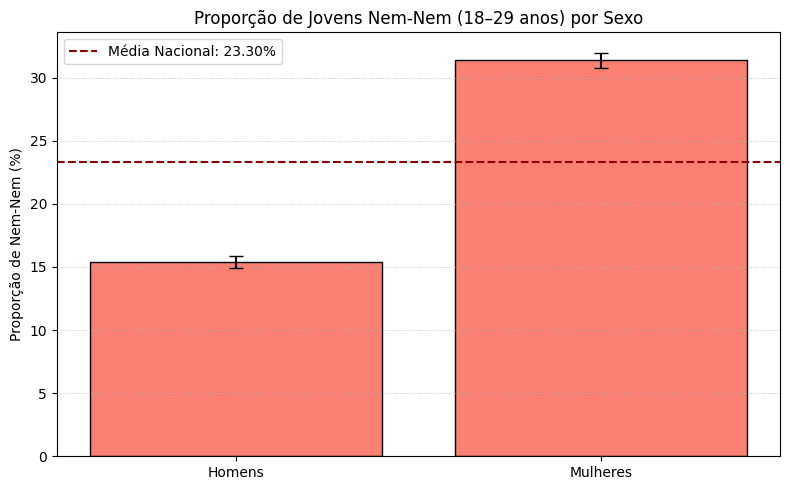

In [73]:
plt.figure(figsize=(8, 5))
plt.bar(df_resultados["sexo"], df_resultados["proporcao_nem_nem"],
        yerr=[df_resultados["proporcao_nem_nem"] - df_resultados["ic_inf"],
              df_resultados["ic_sup"] - df_resultados["proporcao_nem_nem"]],
        capsize=5, color="salmon", edgecolor="black")

plt.axhline(prop_nacional, color="darkred", linestyle="--", label=f"Média Nacional: {prop_nacional:.2f}%")
plt.ylabel("Proporção de Nem-Nem (%)")
plt.title("Proporção de Jovens Nem-Nem (18–29 anos) por Sexo")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
def classificar_jovem(row):
    if row["estuda"] == 1 and row["trabalha"] == 1:
        return "Estuda e Trabalha"
    elif row["estuda"] == 1:
        return "Apenas Estuda"
    elif row["trabalha"] == 1:
        return "Apenas Trabalha"
    else:
        return "Nem-Nem"

jovens["status"] = jovens.apply(classificar_jovem, axis=1)

# Proporções ponderadas por status
distribuicao = jovens.groupby("status").apply(
    lambda g: (g["V1028"].sum()) / jovens["V1028"].sum() * 100
).reset_index(name="proporcao")

print(distribuicao)

              status  proporcao
0      Apenas Estuda   9.869744
1    Apenas Trabalha  54.356335
2  Estuda e Trabalha  12.474951
3            Nem-Nem  23.298970


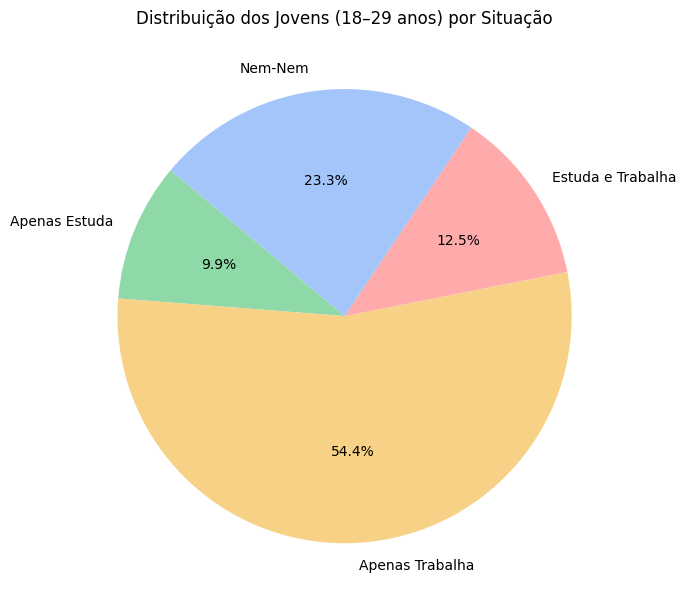

In [75]:
plt.figure(figsize=(7, 7))
plt.pie(distribuicao["proporcao"], labels=distribuicao["status"], autopct="%.1f%%",
        colors=["#8fd9a8", "#f6d186", "#ffabab", "#a4c5f9"], startangle=140)
plt.title("Distribuição dos Jovens (18–29 anos) por Situação")
plt.tight_layout()
plt.show()

## 6.4 Taxa de Pobreza
### Variáveis:

VD4019: rendimento domiciliar per capita,

UF: unidade da federação,

V1028: peso amostral,

V4019: rendimento do trabalho.

### Passos:

Calcular renda per cápita por domicilio

Mapear a Renda per Cápita

Definir a linha de pobreza

Aplicar bootstraps

Visualização Gráfica.

In [18]:
# Criar o ID único por domicílio
df_pnad["id_domicilio"] = df_pnad["UPA"].astype(str) + "_" + df_pnad["V1008"].astype(str) + "_" + df_pnad["V1014"].astype(str)

# Obter número de moradores por domicílio
moradores_por_domicilio = df_pnad.groupby("id_domicilio")["V1028"].count()

# Obter renda domiciliar total por domicílio (soma da renda per capita * número de pessoas no domicílio)
renda_total_domicilio = df_pnad.groupby("id_domicilio")["VD4019"].sum()

# Calcular renda per capita média para o domicílio
renda_per_capita_domicilio = renda_total_domicilio / moradores_por_domicilio

# Mapear renda per capita de volta para o DataFrame original
df_pnad["renda_per_capita"] = df_pnad["id_domicilio"].map(renda_per_capita_domicilio)


In [19]:
# Salário mínimo do ano de referência (ex: 2024: R$ 1.412.00)
salario_minimo = 1.412
linha_pobreza = salario_minimo / 2

# Variável binária de pobreza
df_pnad["pobre"] = (df_pnad["renda_per_capita"] < linha_pobreza).astype(int)


In [20]:
# Proporção ponderada nacional
prop_nacional, ic_nacional = bootstrap_ci(df_pnad, "pobre", "V1028")
prop_nacional *= 100
ic_nacional = (ic_nacional[0]*100, ic_nacional[1]*100)

print(f"Taxa nacional de pobreza: {prop_nacional:.2f}%")
print(f"IC 95%: ({ic_nacional[0]:.2f}%, {ic_nacional[1]:.2f}%)")

Taxa nacional de pobreza: 15.61%
IC 95%: (15.48%, 15.74%)


In [21]:
ufs = df_pnad["UF"].unique()
resultados_uf = []

for uf in sorted(ufs):
    df_uf = df_pnad[df_pnad["UF"] == uf]
    prop, ic = bootstrap_ci(df_uf, "pobre", "V1028")
    resultados_uf.append({
        "UF": uf,
        "proporcao": prop * 100,
        "ic_inf": ic[0] * 100,
        "ic_sup": ic[1] * 100
    })

df_uf_pobreza = pd.DataFrame(resultados_uf).sort_values(by="proporcao", ascending=False)

In [22]:
df_uf_pobreza

,UF,proporcao,ic_inf,ic_sup
9,23,24.121311,23.446691,24.738478
13,27,23.633162,23.064750,24.319461
10,24,23.482511,22.487502,24.536200
12,26,23.083067,22.403234,23.753049
7,21,22.013920,21.475879,22.575577
11,25,21.137099,20.355468,21.853810
15,29,20.881994,20.274246,21.521966
8,22,20.577212,19.780213,21.404684
14,28,20.095867,19.204836,20.979618
1,12,19.526206,18.653028,20.445826


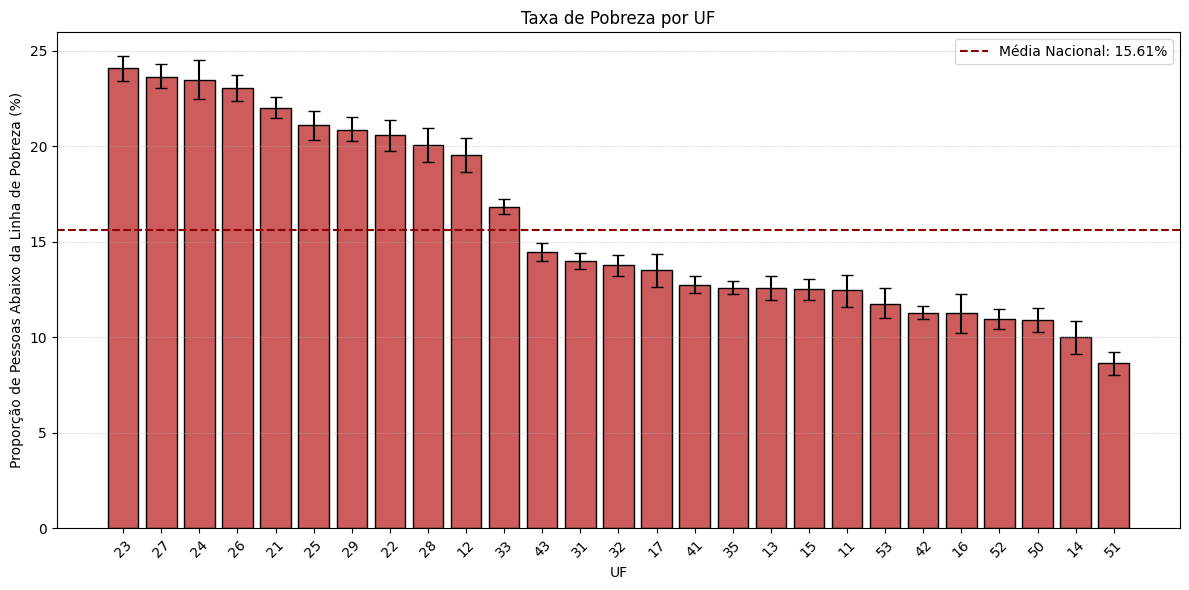

In [23]:
plt.figure(figsize=(12, 6))
plt.bar(df_uf_pobreza["UF"].astype(str), df_uf_pobreza["proporcao"],
        yerr=[df_uf_pobreza["proporcao"] - df_uf_pobreza["ic_inf"],
              df_uf_pobreza["ic_sup"] - df_uf_pobreza["proporcao"]],
        capsize=4, color="indianred", edgecolor="black")

plt.axhline(prop_nacional, color="darkred", linestyle="--", label=f"Média Nacional: {prop_nacional:.2f}%")
plt.title("Taxa de Pobreza por UF")
plt.ylabel("Proporção de Pessoas Abaixo da Linha de Pobreza (%)")
plt.xlabel("UF")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()